Hello friends,

This notebook demonstrates how to pretrain the RoBERTa base model on a binary classification problem for simple and normal Wikipedia abstracts.

The dataset used for this pretraining is the [Simple/Normal Wikiepdia Abstracts V1](https://www.kaggle.com/markwijkhuizen/simplenormal-wikipedia-abstracts-v1) dataset containing ~250K simple and normal Wikipedia abstract with an equal distribution.

[This](https://www.kaggle.com/haki namz/simple-normal-wikipedia-abstract-dataset) notebook gives a demonstration on how the dataset was created.

RoBERTa is trained for masked-language modeling, which is predicting a masked word in a sentence. This task does learn RoBERTa to understand language, but has little in common with the CommonLit competition task. Pretraining RoBERTa on an actual readability prediction task should finetune the model for readability related tasks, such as the CommonLit competition.

In [1]:
import warnings
warnings.simplefilter('ignore')

# Load Necessary Liabraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa

from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize, sent_tokenize
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from scipy.stats import pearsonr
from transformers import RobertaTokenizer, TFRobertaModel

import os
import sys
import nltk
import string
import math
import logging
import glob
import random

tf.get_logger().setLevel(logging.ERROR)
        
tqdm.pandas()

print(f'tensorflow version: {tf.__version__}')
print(f'tensorflow keras version: {tf.keras.__version__}')
print(f'python version: P{sys.version}')

tensorflow version: 2.4.1
tensorflow keras version: 2.4.0
python version: P3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]


In [6]:
# Seed all random sources
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
set_seeds(42)

In [7]:
SEQ_LENGTH = 250

train = pd.read_pickle('/kaggle/input/simplenormal-wikipedia-abstracts-v1/wikipedia_abstracts.pkl')

The linguistic features will not be used in this notebook, but are saved as strings to reduce memory consumption and can be decoded using ```s.split(chr(0))```

In [8]:
# Example of accessing the part of speech feature
print(train.loc[0, 'pos'].split(chr(0)))

['DET', 'CCONJ', 'DET', 'AUX', 'DET', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT', 'DET', 'ADJ', 'NOUN', 'PUNCT', 'DET', 'CCONJ', 'DET', 'PUNCT', 'AUX', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'PUNCT', 'ADV', 'PRON', 'AUX', 'VERB', 'PUNCT', 'PROPN', 'AUX', 'VERB', 'ADP', 'DET', 'ADJ', 'DET', 'PUNCT', 'DET', 'NOUN', 'ADP', 'PROPN', 'CCONJ', 'PROPN', 'PROPN', 'AUX', 'ADJ', 'ADP', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT', 'DET', 'AUX', 'PART', 'ADJ', 'PUNCT', 'SCONJ', 'PRON', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT', 'PUNCT', 'NOUN', 'CCONJ', 'NOUN', 'PUNCT', 'PUNCT', 'DET', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT', 'VERB', 'ADP', 'VERB', 'ADP', 'DET', 'NOUN', 'PUNCT', 'ADP', 'ADJ', 'NOUN', 'PUNCT', 'DET', 'NOUN', 'PROPN', 'AUX', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT', 'ADP', 'PROPN', 'CCONJ', 'ADP', 'PROPN', 'ADP', 'ADJ', 'NOUN', 'PUNCT', 'DET', 'NOUN', 'PROPN', 'AUX', 'NUM', 'PUNCT', 'DET', 'AUX', 'DET', 'NOUN', 'DET', 'AUX', '

In [9]:
display(train.head())

,title,abstract_original,abstract_clean,clean_words,words_wo_stopwords,n_words,n_words_wo_stopwords,sentences,n_sentences,lemma,pos,tag,dep,shape,is_alpha,is_stop,label,label_int
0,A,A or a is the first letter of the English alph...,A or a is the first letter of the English alph...,A or a is the first letter of the English alph...,A first letter English alphabet . The small le...,166,97,[A or a is the first letter of the English alp...,10,a or a be the first letter of the english alph...,DET CCONJ DET AUX DET ADJ NOUN ADP DET ADJ NOU...,"DT CC DT VBZ DT JJ NN IN DT JJ NN . DT JJ NN ,...",nsubj cc conj ROOT det amod attr prep det amod...,X xx x xx xxx xxxx xxxx xx xxx Xxxxx xxxx . Xx...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, False, Tr...",Simple Wikipedia,0
1,Abbreviation,An abbreviation is a shorter way to write a wo...,An abbreviation is a shorter way to write a wo...,An abbreviation is a shorter way to write a wo...,An abbreviation shorter way write word phrase ...,251,172,[An abbreviation is a shorter way to write a w...,13,an abbreviation be a short way to write a word...,DET NOUN AUX DET ADJ NOUN PART VERB DET NOUN C...,DT NN VBZ DT JJR NN TO VB DT NN CC NN . NNS VB...,det nsubj ROOT det amod attr aux relcl det dob...,Xx xxxx xx x xxxx xxx xx xxxx x xxxx xx xxxx ....,"[True, True, True, True, True, True, True, Tru...","[True, False, True, True, False, False, True, ...",Simple Wikipedia,0
2,Ad hominem,Ad hominem is a Latin word for a type of argum...,Ad hominem is a Latin word for a type of argum...,Ad hominem is a Latin word for a type of argum...,Ad hominem Latin word type argument . It word ...,225,133,[Ad hominem is a Latin word for a type of argu...,14,ad hominem be a latin word for a type of argum...,NOUN NOUN AUX DET ADJ NOUN ADP DET NOUN ADP NO...,NN NN VBZ DT JJ NN IN DT NN IN NN . PRP VBZ DT...,compound nsubj ROOT det amod attr prep det pob...,Xx xxxx xx x Xxxxx xxxx xxx x xxxx xx xxxx . X...,"[True, True, True, True, True, True, True, Tru...","[False, False, True, True, False, False, True,...",Simple Wikipedia,0
3,Adobe Illustrator,Adobe Illustrator is a computer program for ma...,Adobe Illustrator is a computer program for ma...,Adobe Illustrator is a computer program for ma...,Adobe Illustrator computer program making grap...,55,33,[Adobe Illustrator is a computer program for m...,4,Adobe Illustrator be a computer program for ma...,PROPN PROPN AUX DET NOUN NOUN ADP VERB ADJ NOU...,NNP NNP VBZ DT NN NN IN VBG JJ NN CC NNS . PRP...,compound nsubj ROOT det compound attr prep pco...,Xxxxx Xxxxx xx x xxxx xxxx xxx xxxx xxxx xxxx ...,"[True, True, True, True, True, True, True, Tru...","[False, False, True, True, False, False, True,...",Simple Wikipedia,0
4,Air,Air refers to the Earth's atmosphere. Air is a...,Air refers to the Earth's atmosphere. Air is a...,Air refers to the Earth 's atmosphere . Air is...,Air refers Earth 's atmosphere . Air mixture m...,358,237,"[Air refers to the Earth's atmosphere., Air is...",27,air refer to the Earth 's atmosphere . air be ...,NOUN VERB ADP DET PROPN PART NOUN PUNCT NOUN A...,NN VBZ IN DT NNP POS NN . NN VBZ DT NN IN JJ N...,nsubj ROOT prep det poss case pobj punct nsubj...,Xxx xxxx xx xxx Xxxxx 'x xxxx . Xxx xx x xxxx ...,"[True, True, True, True, True, False, True, Fa...","[False, False, True, True, False, True, False,...",Simple Wikipedia,0


In [10]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245103 entries, 0 to 245102
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   title                 245103 non-null  object
 1   abstract_original     245103 non-null  object
 2   abstract_clean        245103 non-null  object
 3   clean_words           245103 non-null  object
 4   words_wo_stopwords    245103 non-null  object
 5   n_words               245103 non-null  int64 
 6   n_words_wo_stopwords  245103 non-null  int64 
 7   sentences             245103 non-null  object
 8   n_sentences           245103 non-null  int64 
 9   lemma                 245103 non-null  object
 10  pos                   245103 non-null  object
 11  tag                   245103 non-null  object
 12  dep                   245103 non-null  object
 13  shape                 245103 non-null  object
 14  is_alpha              245103 non-null  object
 15  is_stop          

None

# Roberta Tokenize

In [11]:
# Define the model name
MODEL = 'roberta-base'

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [12]:
# This function tokenize the text according to a transformers model tokenizer
def regular_encode(excerpt):
    enc_di = tokenizer.batch_encode_plus(
        excerpt,
        padding = 'max_length',
        truncation = True,
        max_length = SEQ_LENGTH,
    )
    
    return np.array(enc_di['input_ids'])

# Compute text encoding, this will take ~5 minutes
train['input_ids'] = regular_encode(train['abstract_clean']).tolist()
display(train.head())

,title,abstract_original,abstract_clean,clean_words,words_wo_stopwords,n_words,n_words_wo_stopwords,sentences,n_sentences,lemma,pos,tag,dep,shape,is_alpha,is_stop,label,label_int,input_ids
0,A,A or a is the first letter of the English alph...,A or a is the first letter of the English alph...,A or a is the first letter of the English alph...,A first letter English alphabet . The small le...,166,97,[A or a is the first letter of the English alp...,10,a or a be the first letter of the english alph...,DET CCONJ DET AUX DET ADJ NOUN ADP DET ADJ NOU...,"DT CC DT VBZ DT JJ NN IN DT JJ NN . DT JJ NN ,...",nsubj cc conj ROOT det amod attr prep det amod...,X xx x xx xxx xxxx xxxx xx xxx Xxxxx xxxx . Xx...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, False, Tr...",Simple Wikipedia,0,"[0, 250, 50, 10, 16, 5, 78, 1601, 9, 5, 2370, ..."
1,Abbreviation,An abbreviation is a shorter way to write a wo...,An abbreviation is a shorter way to write a wo...,An abbreviation is a shorter way to write a wo...,An abbreviation shorter way write word phrase ...,251,172,[An abbreviation is a shorter way to write a w...,13,an abbreviation be a short way to write a word...,DET NOUN AUX DET ADJ NOUN PART VERB DET NOUN C...,DT NN VBZ DT JJR NN TO VB DT NN CC NN . NNS VB...,det nsubj ROOT det amod attr aux relcl det dob...,Xx xxxx xx x xxxx xxx xx xxxx x xxxx xx xxxx ....,"[True, True, True, True, True, True, True, Tru...","[True, False, True, True, False, False, True, ...",Simple Wikipedia,0,"[0, 4688, 45986, 46021, 16, 10, 10941, 169, 7,..."
2,Ad hominem,Ad hominem is a Latin word for a type of argum...,Ad hominem is a Latin word for a type of argum...,Ad hominem is a Latin word for a type of argum...,Ad hominem Latin word type argument . It word ...,225,133,[Ad hominem is a Latin word for a type of argu...,14,ad hominem be a latin word for a type of argum...,NOUN NOUN AUX DET ADJ NOUN ADP DET NOUN ADP NO...,NN NN VBZ DT JJ NN IN DT NN IN NN . PRP VBZ DT...,compound nsubj ROOT det amod attr prep det pob...,Xx xxxx xx x Xxxxx xxxx xxx x xxxx xx xxxx . X...,"[True, True, True, True, True, True, True, Tru...","[False, False, True, True, False, False, True,...",Simple Wikipedia,0,"[0, 9167, 9486, 10748, 16, 10, 5862, 2136, 13,..."
3,Adobe Illustrator,Adobe Illustrator is a computer program for ma...,Adobe Illustrator is a computer program for ma...,Adobe Illustrator is a computer program for ma...,Adobe Illustrator computer program making grap...,55,33,[Adobe Illustrator is a computer program for m...,4,Adobe Illustrator be a computer program for ma...,PROPN PROPN AUX DET NOUN NOUN ADP VERB ADJ NOU...,NNP NNP VBZ DT NN NN IN VBG JJ NN CC NNS . PRP...,compound nsubj ROOT det compound attr prep pco...,Xxxxx Xxxxx xx x xxxx xxxx xxx xxxx xxxx xxxx ...,"[True, True, True, True, True, True, True, Tru...","[False, False, True, True, False, False, True,...",Simple Wikipedia,0,"[0, 9167, 14004, 36599, 24362, 16, 10, 3034, 5..."
4,Air,Air refers to the Earth's atmosphere. Air is a...,Air refers to the Earth's atmosphere. Air is a...,Air refers to the Earth 's atmosphere . Air is...,Air refers Earth 's atmosphere . Air mixture m...,358,237,"[Air refers to the Earth's atmosphere., Air is...",27,air refer to the Earth 's atmosphere . air be ...,NOUN VERB ADP DET PROPN PART NOUN PUNCT NOUN A...,NN VBZ IN DT NNP POS NN . NN VBZ DT NN IN JJ N...,nsubj ROOT prep det poss case pobj punct nsubj...,Xxx xxxx xx xxx Xxxxx 'x xxxx . Xxx xx x xxxx ...,"[True, True, True, True, True, False, True, Fa...","[False, False, True, True, False, True, False,...",Simple Wikipedia,0,"[0, 17906, 12859, 7, 5, 3875, 18, 5466, 4, 175..."


# Hardware Configuration

In [13]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

# set half precision policy
mixed_precision.set_policy('float32')

print(f'Compute dtype: {mixed_precision.global_policy().compute_dtype}')
print(f'Variable dtype: {mixed_precision.global_policy().variable_dtype}')

Running on GPU
REPLICAS: 1
Compute dtype: float32
Variable dtype: float32


# Model

In [14]:
def get_model():
    tf.keras.backend.clear_session()

    with strategy.scope():
        # RoBERTa
        transformer = TFRobertaModel.from_pretrained(MODEL)
        input_ids = tf.keras.layers.Input(shape = (SEQ_LENGTH), dtype=tf.int32, name='input_ids')
        sequence_output = transformer(input_ids)[0]
        # We only need the cls_token, resulting in a 2d array
        cls_token = sequence_output[:, 0, :]
        # 2 output neurons for Simple and Normal class
        output = tf.keras.layers.Dense(2, activation='softmax', dtype=tf.float32)(cls_token)
        
        model = tf.keras.models.Model(inputs = [input_ids], outputs = [output])

        loss = tf.keras.losses.SparseCategoricalCrossentropy()
        optimizer = tf.optimizers.Adam(learning_rate=1e-5)
        metrics = [
            tf.keras.metrics.SparseCategoricalAccuracy('accuracy'),
        ]

        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)            
    
    return model

model = get_model()

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 250)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM TFBaseModelOutputWithPool 124645632 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1538      
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
_________________________________________________________________


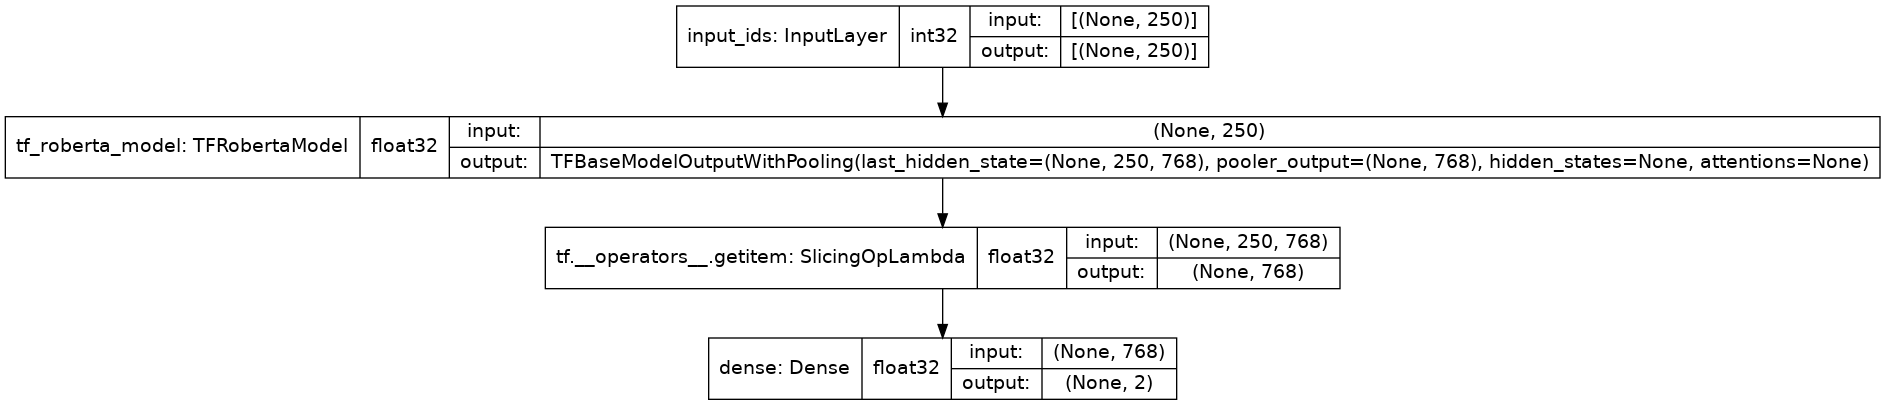

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=False)

# Configuration

In [18]:
# Training configuration
BATCH_SIZE_BASE = 32
BATCH_SIZE = BATCH_SIZE_BASE * REPLICAS
STEPS_PER_EPOCH = 100
EPOCHS = len(train) // (STEPS_PER_EPOCH * BATCH_SIZE)
KFOLDS = 5

print(f'BATCH SIZE: {BATCH_SIZE}, EPOCHS: {EPOCHS}')

BATCH SIZE: 32, EPOCHS: 76


# Dataset

In [19]:
def get_train_dataset():
    # Randomize the dataset order, otherwise the model will first be trained on Simple abstracts only
    idxs = np.arange(len(train))
    random.Random(42).shuffle(idxs)
    
    train_x = { 
        'input_ids': np.array(train.loc[idxs, 'input_ids'].tolist()),
    }
    train_y = train.loc[idxs, 'label_int']
    
    train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
    
    train_dataset = train_dataset.batch(BATCH_SIZE)
    
    return train_dataset

train_dataset = get_train_dataset()

In [20]:
# Example of a batch
train_x, train_y = next(iter(train_dataset))
print(f'train_x keys: {list(train_x.keys())}, train_x shape: {train_x["input_ids"].shape}')
print(f'train_y shape: {train_y.shape}, train_y dtype {train_y.dtype}')
print(f'labels: {train_y}')

train_x keys: ['input_ids'], train_x shape: (32, 250)
train_y shape: (32,), train_y dtype <dtype: 'int64'>
labels: [1 0 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0]


# Training

Training will be split in epochs of 100 steps and the dataset will be iterated once. This means all data will be seen for the first time and the training accuracy can be interpreted as validation accuracy, because no sample will be used for training twice. Training will take roughly 1.5 hours.

# Training History

Training metrics are shown here, an accuracy of 90\%+ is achieved!

In [27]:
def plot_history_metric(history, metric):
    plt.figure(figsize=(15, 8))
    N_EPOCHS = len(history.history['loss'])
    x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]
    x_ticks = np.arange(1, N_EPOCHS+1)
    val = 'val' in ''.join(history.history.keys())
    # summarize history for accuracy
    plt.plot(x_ticks, history.history[metric])
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = np.argmin(val_values)
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='red', s=50, marker='o')
        plt.plot(x_ticks, val_values)
    
    plt.title(f'Model {metric}', fontsize=24)
    plt.ylabel(metric, fontsize=18)
    plt.xlabel('epoch', fontsize=18)
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    plt.legend(['train'] + ['test'] if val else ['train'],  prop={'size': 18})
    plt.grid()

In [29]:
plot_history_metric(history, 'accuracy')

NameError: name 'history' is not defined

# Save pretrained RoBERTa layer

In [30]:
# Save RoBERTa weight
for l_idx, l in enumerate(model.layers):
    print(l.name)
    if l.name == 'tf_roberta_model':
        print(f'Saving layer {l_idx} with name {l.name}')
        l.save_weights('roberta_pretrained.h5')

input_ids
tf_roberta_model
Saving layer 1 with name tf_roberta_model
tf.__operators__.getitem
dense


# CommonLit Model

Thee next function gives an example on how to use the pretrained weights in a model for CommonLit training. It is as simple using the ```load_weights``` function for the RoBERTa layer.

In [31]:
def get_model():
    tf.keras.backend.clear_session()

    with strategy.scope():
        # RoBERTa
        transformer = TFRobertaModel.from_pretrained(MODEL)
        # Load saved weights
        transformer.load_weights('roberta_pretrained.h5')
        
        input_ids = tf.keras.layers.Input(shape = (SEQ_LENGTH), dtype=tf.int32, name='input_ids')
        sequence_output = transformer(input_ids)[0]
        # We only need the cls_token, resulting in a 2d array
        cls_token = sequence_output[:, 0, :]
        output = tf.keras.layers.Dense(1, activation='linear', dtype=tf.float32)(cls_token)
        
        # Model
        model = tf.keras.models.Model(inputs=input_ids, outputs=output)

        loss = tf.keras.losses.MeanSquaredError()
        optimizer = tf.optimizers.Adam(learning_rate=4e-5)
        metrics = [
            tf.keras.metrics.RootMeanSquaredError(name='RMSE'),
        ]

        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

model = get_model()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 250)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM TFBaseModelOutputWithPool 124645632 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 124,646,401
Trainable params: 124,646,401
Non-trainable params: 0
_________________________________________________________________
